## Process embeddings


In [9]:
import pandas as pd
import numpy as np
import h5py
from glob import glob

In [10]:
embeddings = glob("../data/ucyn-a_enriched/embeddings/*.csv")
dfs = [(e, pd.read_csv(e)) for e in embeddings]

In [11]:
dfs[0][0].split("/")[-1].split(".")[0]

'KC1-P2_N3_k43_Locus_28_Transcript_1_1'

In [12]:
# Write embeddings to H5 file
with h5py.File("../data/ucyn-a_enriched/embeddings.h5", "w") as f:
    for i, (name, df) in enumerate(dfs):
        name = name.split("/")[-1].split(".")[0] + " Cytoplasm-U new_test_set"
        f.create_dataset(name, data=df.values)

## Process Predictions


In [1]:
import pandas as pd
from Bio import SeqIO
from matplotlib import pyplot as plt

In [2]:
ids = [seq.id for seq in SeqIO.parse("../data/ucyn-a_enriched/ucyn-a_enriched.fasta", "fasta")]
df = pd.read_csv(
    "../data/ucyn-a_enriched/localizations.txt", header=None, names=["localization"]
)
df["id"] = ids

# Plot localization distribution
df["localization"].value_counts().plot(kind="bar")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/ucyn-a_enriched/localizations.txt'

## MuLocDeep


In [3]:
import pandas as pd
import numpy as np
from glob import glob
from Bio import SeqIO, AlignIO
from matplotlib import pyplot as plt
from collections import defaultdict

In [4]:
alignment = AlignIO.read("../data/ucyn-a_enriched/ucyn-a_enriched_cobalt.fa", "fasta")
for align in alignment:
    new_id = " ".join(align.description.split(" ")[1:])
    align.id = new_id
    align.description = ""

alignment_dict = {record.id: record.seq for record in alignment}

In [5]:
# Parse predictions
attention_weights_str = "\n".join(
    open(f).read()
    for f in glob("../data/ucyn-a_enriched/mulocdeep-localization/*/attention_weights.txt")
)
sub_cellular_prediction_str = "\n".join(
    open(f).read()
    for f in glob(
        "../data/ucyn-a_enriched/mulocdeep-localization/*/sub_cellular_prediction.txt"
    )
)
sub_organellar_prediction_str = "\n".join(
    open(f).read()
    for f in glob(
        "../data/ucyn-a_enriched/mulocdeep-localization/*/sub_organellar_prediction.txt"
    )
)

attention_weights = {}
attention_weights_lines = attention_weights_str.split("\n")
while len(attention_weights_lines) > 0:
    line = attention_weights_lines.pop(0).strip()
    if line == "":
        continue
    if line.startswith(">"):
        prot_id = line[1:]
        line = attention_weights_lines.pop(0).strip()
        attention_weights[prot_id] = np.array([float(x) for x in line.split(" ")])

sub_cellular_predictions = {}
for line in sub_cellular_prediction_str.split("\n"):
    line = line.strip()
    if line == "":
        continue
    prot_id, pred = line.split(":", maxsplit=1)
    prot_id = prot_id.strip()[1:]
    sub_cellular_predictions[prot_id] = {}
    for p in pred.split("\t"):
        p = p.strip()
        if p == "":
            continue
        target, prob = p.split(":")
        if target == "prediction":
            continue
        prob = float(prob)
        sub_cellular_predictions[prot_id][target] = prob
    
sub_organellar_predictions = {}
for line in sub_organellar_prediction_str.split("\n"):
    line = line.strip()
    if line == "":
        continue
    prot_id, pred = line.split(":", maxsplit=1)
    prot_id = prot_id.strip()[1:]
    sub_organellar_predictions[prot_id] = {}
    for p in pred.split("\t"):
        p = p.strip()
        if p == "":
            continue
        target, prob = p.split(":")
        if target == "prediction":
            continue
        prob = float(prob)
        sub_organellar_predictions[prot_id][target] = prob

In [6]:
total_probs["Secreted"]

27.886734144237234

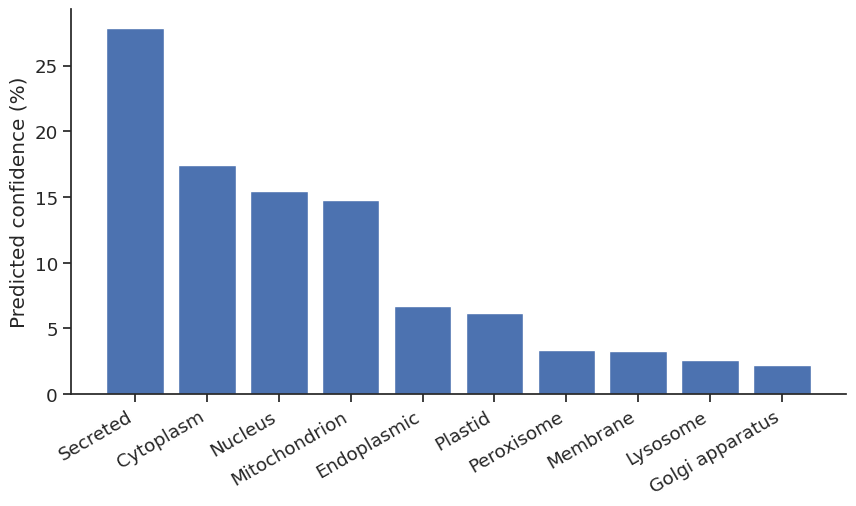

In [21]:
import seaborn as sns
sns.set_theme("paper")
sns.set(font_scale=1.2)
sns.set_style("ticks")


subcell_loc_categories = set(list(sub_cellular_predictions.values())[0].keys())
total_probs = defaultdict(lambda: 0)
for _, targets in sub_cellular_predictions.items():
    for t, p in targets.items():
        total_probs[t] += p

# Normalize
total_p = sum(total_probs.values())
for i in total_probs:
    total_probs[i] /= total_p

# Sort by probability
total_probs = dict(sorted(total_probs.items(), key=lambda x: x[1], reverse=True))

# Rename categories
total_probs = { k.replace("_", " "): v*100 for k, v in total_probs.items() }

plt.figure(figsize=(10, 5))
plt.bar(total_probs.keys(), total_probs.values())
plt.xticks(rotation=30, ha='right')
plt.ylabel("Predicted confidence (%)")
sns.despine()

# plt.show()
plt.savefig("../../figures/localization_classification.svg", bbox_inches="tight")

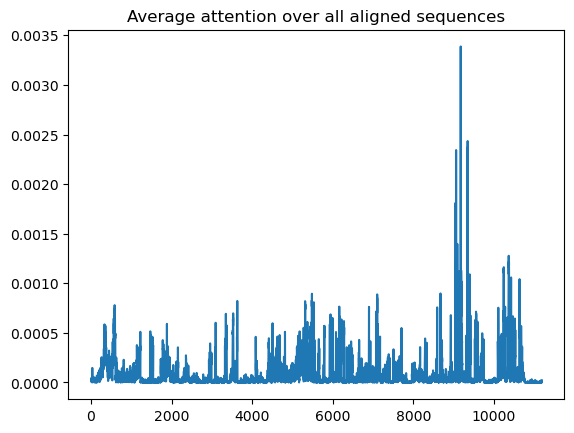

In [20]:
# Plot the average attention over all aligned sequences

align_len = len(alignment_dict[list(attention_weights.keys())[0]])
num_seqs = len(alignment_dict)
total_attn = np.zeros(align_len)

for seq_id, req in alignment_dict.items():
    attn_vec = attention_weights[seq_id]
    
    # Create alignment map
    alignment_map = {}
    unaligned_idx = 0
    for idx, res in enumerate(req):
        if res != "-":
            alignment_map[unaligned_idx] = idx
            unaligned_idx += 1
            
    # Align attention vector
    for idx, w in enumerate(attn_vec):
        total_attn[alignment_map[idx]] += w
        
avg_attn = total_attn / num_seqs

plt.plot(avg_attn)
plt.title("Average attention over all aligned sequences")
plt.show()

In [21]:
def compute_attention_per_normalized_position(attention_weights):
    attn = defaultdict(lambda: 0)
    for _, attn_vec in attention_weights.items():
        for idx, w in enumerate(attn_vec):
            normalized_pos = idx / len(attn_vec)
            attn[normalized_pos] += w
            
    attn = sorted(attn.items(), key=lambda x: x[0])
    attn_x = [x[0] for x in attn]
    attn_y = [x[1] for x in attn]
    return attn_x, attn_y

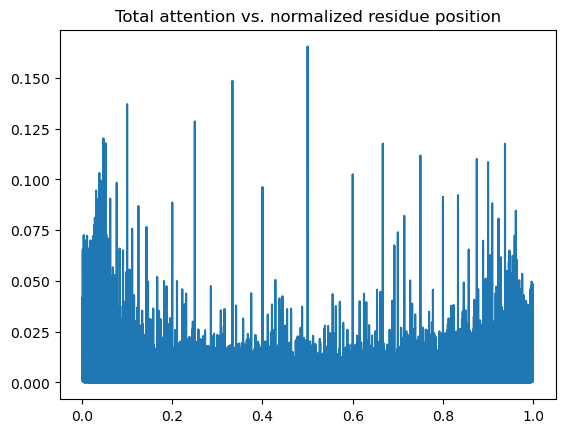

In [22]:
attn_x, attn_y = compute_attention_per_normalized_position(attention_weights)

plt.plot(attn_x[1:], attn_y[1:])
plt.title("Total attention vs. normalized residue position")
plt.show()

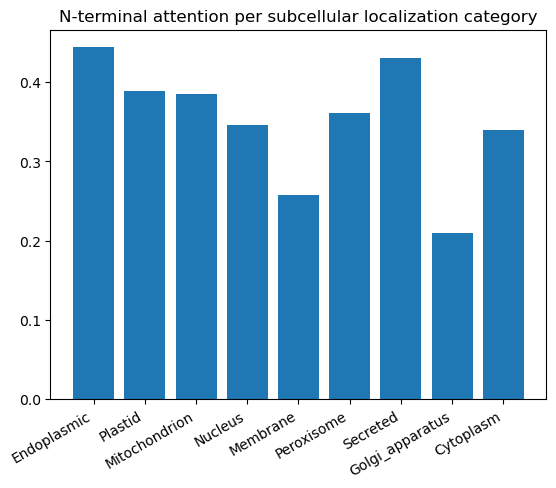

In [23]:
n_term_frac = 0.2   
subcell_loc_categories = set(list(sub_cellular_predictions.values())[0].keys())

n_term_attn_per_cat = {}
for cat in subcell_loc_categories:
    seq_ids = [k for k, v in sub_cellular_predictions.items() if cat == max(v.keys(), key=lambda x: v[x])]
    attn = {k: attention_weights[k] for k in seq_ids}
    attn_x, attn_y = compute_attention_per_normalized_position(attn)
    if sum(attn_y) == 0:
        continue
    n_terminal_attention = sum(attn_y[:int(len(attn_y) * n_term_frac)])
    non_n_terminal_attention = sum(attn_y)
    n_term_attn_per_cat[cat] = n_terminal_attention / non_n_terminal_attention
    
plt.bar(n_term_attn_per_cat.keys(), n_term_attn_per_cat.values())
plt.xticks(rotation=30, ha='right')
plt.title("N-terminal attention per subcellular localization category")
plt.show()

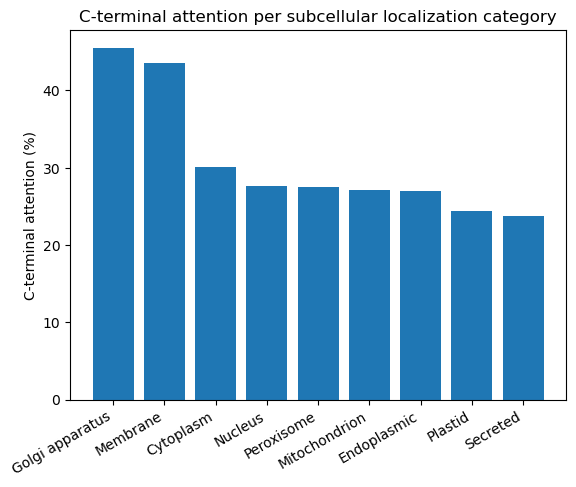

In [24]:
c_term_frac = 0.2

c_term_attn_per_cat = {}
for cat in subcell_loc_categories:
    seq_ids = [k for k, v in sub_cellular_predictions.items() if cat == max(v.keys(), key=lambda x: v[x])]
    attn = {k: attention_weights[k] for k in seq_ids}
    attn_x, attn_y = compute_attention_per_normalized_position(attn)
    if sum(attn_y) == 0:
        continue
    c_terminal_attention = sum(attn_y[-int(len(attn_y) * c_term_frac):])
    non_c_terminal_attention = sum(attn_y)
    c_term_attn_per_cat[cat] = (c_terminal_attention / non_c_terminal_attention) * 100

# Sort by value
c_term_attn_per_cat = {k.replace("_", " "): v for k, v in sorted(c_term_attn_per_cat.items(), key=lambda x: x[1], reverse=True)}

plt.bar(c_term_attn_per_cat.keys(), c_term_attn_per_cat.values())
plt.xticks(rotation=30, ha='right')
plt.title("C-terminal attention per subcellular localization category")
plt.ylabel("C-terminal attention (%)")
plt.show()

ValueError: too many values to unpack (expected 2)

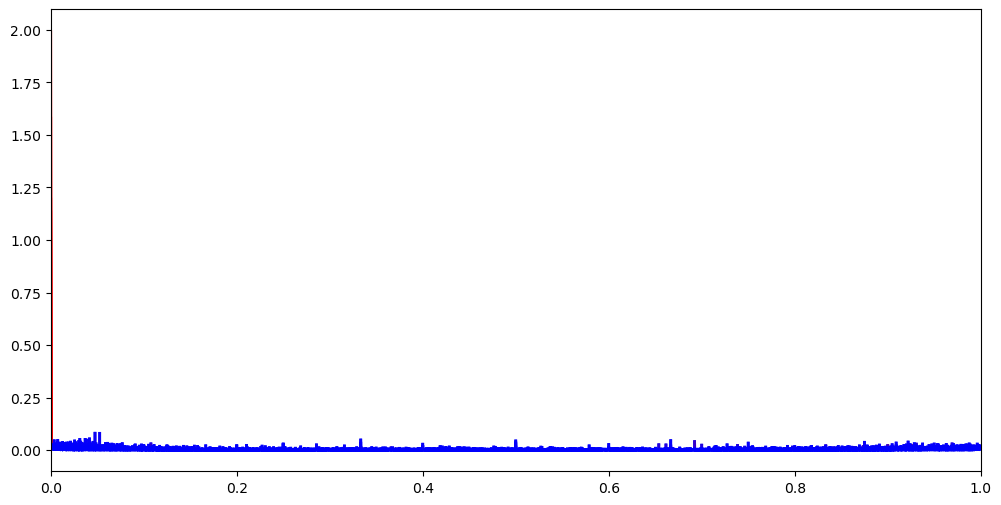

In [26]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

def compute_attention_per_normalized_position(attention_weights):
    attn = defaultdict(float)
    for attn_vec in attention_weights.values():
        for idx, w in enumerate(attn_vec):
            normalized_pos = idx / len(attn_vec)
            attn[normalized_pos] += w
    return sorted(attn.items())

def plot_attention_for_categories(attention_weights, sub_cellular_predictions):
    plt.figure(figsize=(12, 6))

    categories = set().union(*sub_cellular_predictions.values())
    colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))

    for category, color in zip(categories, colors):
        # Get sequences for this category
        seq_ids = [k for k, v in sub_cellular_predictions.items() 
                   if category == max(v, key=v.get)]
        
        # Compute average attention for this category
        category_attn = {k: attention_weights[k] for k in seq_ids if k in attention_weights}
        if not category_attn:
            continue
        
        attn_x, attn_y = zip(*compute_attention_per_normalized_position(category_attn))
        
        # Create line segments
        points = np.array([attn_x, attn_y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(min(attn_y), max(attn_y))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list("", ["blue", "red"])
        
        # Create the line collection object
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(np.array(attn_y))
        lc.set_linewidth(2)
        
        # Add the line collection to the plot
        line = plt.gca().add_collection(lc)
        
        # Add a label for the legend
        plt.plot([], [], color=color, label=category.replace('_', ' '))

    plt.xlim(0, 1)
    plt.ylim(min(min(attn_y) for attn_x, attn_y in [compute_attention_per_normalized_position(category_attn) for category_attn in [
        {k: attention_weights[k] for k in seq_ids if k in attention_weights}
        for seq_ids in [[k for k, v in sub_cellular_predictions.items() if category == max(v, key=v.get)]
                        for category in categories]
    ] if category_attn]),
             max(max(attn_y) for attn_x, attn_y in [compute_attention_per_normalized_position(category_attn) for category_attn in [
        {k: attention_weights[k] for k in seq_ids if k in attention_weights}
        for seq_ids in [[k for k, v in sub_cellular_predictions.items() if category == max(v, key=v.get)]
                        for category in categories]
    ] if category_attn]))
    
    plt.colorbar(line, label='Attention Value')
    plt.xlabel('Normalized Sequence Position')
    plt.ylabel('Average Attention')
    plt.title('Attention Distribution for Localization Categories')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Assuming attention_weights and sub_cellular_predictions are already defined
plot_attention_for_categories(attention_weights, sub_cellular_predictions)
